<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/video_notebooks/08_introduction_to_nlp_in_tensorflow_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving informaton out of natural language (could be seqeuences text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq).

> 📖 **Resource:** See all course materials, resources and extra-curriculum for this notebook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/

## Check for GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-a1b19013-e9dc-a380-ac72-f245433843e9)


## Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2021-04-14 05:57:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9304 (9.1K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.09K  --.-KB/s    in 0s      

2021-04-14 05:57:54 (50.0 MB/s) - ‘helper_functions.py’ saved [9304/9304]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as diaster or not diaster).

See the original source here: https://www.kaggle.com/c/nlp-getting-started

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2021-04-14 05:57:56--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 108.177.15.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2021-04-14 05:57:57 (81.0 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-files-python/

But I prefer to get visual straight away.

So another way to do this is to use pandas...

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) 
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real diaster)" if target > 0 else "(not real diaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real diaster)
Text:
Do you have a plan in case of a pool chemical emergency? Learn more here: http://t.co/UePPjwvLcb #watersafety @CDC

---

Target: 0 (not real diaster)
Text:
I crashed my car into a parked car the other day... #modestmouseremix #truestory

---

Target: 0 (not real diaster)
Text:
smokers that ruin that new car smell ????

---

Target: 1 (real diaster)
Text:
#computers #gadgets Two giant cranes holding a bridge collapse into nearby homes http://t.co/UZIWgZRynY #slingnews

---

Target: 0 (not real diaster)
Text:
I love the sound of thunder rumbling across the mountains.

---



### Split data into training and validation sets

We want to be able to see how our model is performing on unseen data whilst it trains.

And because the testing dataset doesn't have labels, we'll have to create a validation dataset to evaluate on (the model won't see the validation dataset during training so we can use its samples and labels to evaluate our model's performance).

In [ ]:
from sklearn.model_selection import train_test_split 

In [ ]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data for validation split
                                                                            random_state=42)

In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# Check the first 10 samples 
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenziation - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [ ]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be?
                                    pad_to_max_tokens=True)

In [ ]:
len(train_sentences[0].split())

7

In [ ]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer instance to the training data using the adapt() method
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
A Rocket To The Moon  ? Sleeping With Sirens ?A Rocket To The Moon ????????????        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   3, 2732,    5,    2, 2038, 1365,   14,  568,    3, 2732,    5,
           2, 2038,    0,    0]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # the most common words in the vocab
bottom_5_words = words_in_vocab[-5:] # the least common words in the vocab
print(f"Most common words in vocab: {top_5_words}")
print(f"Least common words in vocab: {bottom_5_words}")

Most common words in vocab: ['', '[UNK]', 'the', 'a', 'in']
Least common words in vocab: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [ ]:
# how long is our vocab?
len(words_in_vocab)

10000

## Creating an Embedding using an Embedding Layer

In [ ]:
max_length,

(15,)

In [ ]:
from tensorflow.keras import layers 

embedding = layers.Embedding(input_dim=max_vocab_length, # set the input shape
                             output_dim=128, # set the size of the embedding vector
                             embeddings_initializer="uniform", # default, initialize embedding vectors randomly
                             input_length=max_length # how long is each input
                             )

embedding

In [ ]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation, aka tokenization first)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Tram travellers evacuated after powerlines come down in Surfers http://t.co/Qsheu3yF0W        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04958296, -0.04139192, -0.04169388, ...,  0.01408607,
         -0.01752247,  0.04459331],
        [-0.03577176, -0.04699584, -0.02933953, ...,  0.03718685,
         -0.02223238,  0.03446043],
        [ 0.00107155, -0.00010961, -0.03292809, ...,  0.00652714,
          0.02232416,  0.01176478],
        ...,
        [-0.03103235, -0.03435149, -0.03189705, ...,  0.02484849,
          0.03722688, -0.04460208],
        [-0.03103235, -0.03435149, -0.03189705, ...,  0.02484849,
          0.03722688, -0.04460208],
        [-0.03103235, -0.03435149, -0.03189705, ...,  0.02484849,
          0.03722688, -0.04460208]]], dtype=float32)>

In [ ]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.04958296, -0.04139192, -0.04169388,  0.00415834, -0.03827494,
        0.04158347,  0.0019039 ,  0.00871357, -0.00932516, -0.01586594,
        0.01528205,  0.04454393, -0.04468231, -0.00108589,  0.00225253,
        0.01448091, -0.03179061, -0.00050277, -0.04112818, -0.00091634,
        0.03626807,  0.00411427, -0.02153314,  0.04078237,  0.03757713,
        0.01344851, -0.03662326, -0.01398536, -0.03565912, -0.03843249,
       -0.0358387 ,  0.00736227, -0.00768409,  0.00970813, -0.02738259,
       -0.00180788, -0.03767512,  0.00508625,  0.03526122, -0.00299063,
        0.00639887,  0.0025234 ,  0.01348929, -0.0276189 ,  0.01180274,
        0.03836086,  0.00347748, -0.02545147,  0.00669122,  0.04385629,
       -0.00325032,  0.03581819,  0.03069656,  0.03818032,  0.04515779,
       -0.0241433 , -0.02243618,  0.00921572,  0.027369  , -0.00890359,
        0.03530747, -0.01672858,  0.02132766, -0.04820118, -0.01790066,
        0.004653

## Modelling a text dataset (setting up our modelling experiments)

Now we've got our data in numerical format, let's start building and comparing different models.

* Model 0: Naive Bayes (baseline) - got this from here: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional LSTM
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Word Embedding (feature extractor)
* Model 7: Same as model 6 but using 10% of data

For each of these models, we're going to be following the TensorFlow steps in modelling:
* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
                    ("clf", MultinomialNB()) # model the text converted to numbers
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

CPU times: user 160 ms, sys: 4.15 ms, total: 164 ms
Wall time: 181 ms


In [ ]:
# Let's evalaute our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

Let's make a function to evaluate our modelling experiment predictions using: 
* Accuracy
* Precision
* Recall
* F1-score

In [ ]:
# Function to evalaute: accuracy, precision, recall, F1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  ----
  y_true = true labels in the form of a 1D array
  y_pred = predicted label in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall and f1-score between y_true and y_pred.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100 # get accuracy score in percentage value
  # Calculate model precision, recall and f1 score using "weighted" avergage
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  # Create a dictionary of model results
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A simple dense model (feed-forward neural network)

In [ ]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [ ]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers 
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [ ]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_sentences,
                        train_labels, 
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                               experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20210414-055804
Epoch 1/5
215/215 [==============================] - 8s 23ms/step - loss: 0.6524 - accuracy: 0.6514 - val_loss: 0.5368 - val_accuracy: 0.7533
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4596 - accuracy: 0.8153 - val_loss: 0.4726 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3493 - accuracy: 0.8604 - val_loss: 0.4570 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2819 - accuracy: 0.8959 - val_loss: 0.4699 - val_accuracy: 0.7992
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2366 - accuracy: 0.9112 - val_loss: 0.4819 - val_accuracy: 0.7913


In [ ]:
# Evaluate model 1
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4819 - accuracy: 0.7913


[0.48192545771598816, 0.7913385629653931]

In [ ]:
# Make predictions with model_1
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

array([[0.35383463],
       [0.81071967],
       [0.99782556],
       [0.10595703],
       [0.08765673],
       [0.93484205],
       [0.9048694 ],
       [0.99414164],
       [0.9482436 ],
       [0.2645767 ]], dtype=float32)

In [ ]:
# Convert model_1 pred probs from probabilities to prediction labels
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [ ]:
# Evaluate model_1 with our evaluation function
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.13385826771653,
 'f1': 0.7880356865491198,
 'precision': 0.7976012509315953,
 'recall': 0.7913385826771654}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [ ]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False,  True])

### Visualizing learned embeddings

To further understand word embeddings, let's visualize them, to do so, we'll get the weights matrix (embedding matrix) from our embedding layer and visualize it using the Embedding project tool, see the TensorFlow guide for more: https://www.tensorflow.org/tutorials/text/word_embeddings

In [ ]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Get the weight matrix of embedding layer
# (the weights are the numerical patterns between the text in the training dataset that the model has learned)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [ ]:
import io

# Code to save trained embeddings to file - we got this from here: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# Let's download the saved embeddings locally
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Our visual word embeddings might not look like much to us, but they help our model understand the relationships between words.

For more on a popular type of word embedding and more visual explanations check out the illustrated word2vec: https://jalammar.github.io/illustrated-word2vec/

## Model 2: LSTM

* LSTM = long short-term memory

For more on RNN's/resources to learn, see here: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb 

We're going to focus on writing the code.

In [ ]:
# Create LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(f"After embedding: {x.shape}")
# x = layers.LSTM(64, activation="tanh", return_sequences=True)(x) # use return_sequences=True if you want to stack recurrent layers 
# print(f"After LSTM cell with return_sequences=True: {x.shape}")
x = layers.LSTM(64, activation="tanh")(x)
print(f"After LSTM cell: {x.shape}")
# x = layers.Dense(64, activation="relu")(x) # optional dense layer to have on top of LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")


After embedding: (None, 15, 128)
After LSTM cell: (None, 64)


In [ ]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
history_2 = model_2.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                               experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20210414-055829
Epoch 1/5
215/215 [==============================] - 34s 27ms/step - loss: 0.2989 - accuracy: 0.8959 - val_loss: 0.5377 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 5s 21ms/step - loss: 0.1550 - accuracy: 0.9440 - val_loss: 0.6231 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.1208 - accuracy: 0.9579 - val_loss: 0.7128 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.1029 - accuracy: 0.9605 - val_loss: 0.8816 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0790 - accuracy: 0.9713 - val_loss: 0.9632 - val_accuracy: 0.7822


In [ ]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

((762, 1), array([[5.2974503e-03],
        [7.5034630e-01],
        [9.9962139e-01],
        [6.2518336e-02],
        [3.7986445e-04],
        [9.9857640e-01],
        [7.8368771e-01],
        [9.9976081e-01],
        [9.9954385e-01],
        [6.7327970e-01]], dtype=float32))

In [ ]:
# Round out pred probs and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate our LSTM model's results
model_2_preds = tf.squeeze(tf.round(model_2_preds))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate our model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 78.21522309711287,
 'f1': 0.7801766074787211,
 'precision': 0.7840694582051416,
 'recall': 0.7821522309711286}

## Model 3: GRU

GRU = Gated recurrent unit (one of the most popular and useful recurrent layer types)

📖 **Resource:** If you want to see the formula for Tanh, a great extension would be to replicate the function in pure TensorFlow, see here: https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh

In [ ]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, activation="tanh", return_sequences=True)(x) # return_sequences=True is required for stacking recurrent cells
# print(x.shape)
x = layers.GRU(64, activation="tanh")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model_3 (GRU)
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20210414-055924
Epoch 1/5
215/215 [==============================] - 8s 27ms/step - loss: 0.2703 - accuracy: 0.8921 - val_loss: 0.8344 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0711 - accuracy: 0.9745 - val_loss: 0.8041 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0677 - accuracy: 0.9724 - val_loss: 1.0618 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0545 - accuracy: 0.9773 - val_loss: 1.2175 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0532 - accuracy: 0.9783 - val_loss: 1.2406 - val_accuracy: 0.7625


In [ ]:
# Make predictions with the trained model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10], model_3_pred_probs.shape

(array([[2.3852123e-04],
        [7.9211944e-01],
        [9.9979848e-01],
        [5.0801184e-02],
        [6.2251114e-05],
        [9.9927169e-01],
        [3.2195503e-01],
        [9.9991918e-01],
        [9.9979550e-01],
        [6.5830976e-01]], dtype=float32), (762, 1))

In [ ]:
# Convert model 3 pred probs into labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate results for model 3
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.24671916010499,
 'f1': 0.75760506518967,
 'precision': 0.7701495378408689,
 'recall': 0.7624671916010499}

## Model 4: Bidirectional RNN model

In [ ]:
# Build a bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # return_sequences=True required for stacking RNN layers
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [ ]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
history_model_4 = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20210414-055952
Epoch 1/5
215/215 [==============================] - 11s 33ms/step - loss: 0.1773 - accuracy: 0.9660 - val_loss: 0.9334 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 6s 26ms/step - loss: 0.0481 - accuracy: 0.9788 - val_loss: 1.1132 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0458 - accuracy: 0.9785 - val_loss: 1.2475 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0549 - accuracy: 0.9740 - val_loss: 1.3507 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0414 - accuracy: 0.9796 - val_loss: 1.2782 - val_accuracy: 0.7717


In [ ]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10], model_4_pred_probs.shape

(array([[3.2934537e-03],
        [7.6064408e-01],
        [9.9996603e-01],
        [2.9276967e-01],
        [1.4514616e-05],
        [9.9951208e-01],
        [6.2776673e-01],
        [9.9999046e-01],
        [9.9994016e-01],
        [5.7673228e-01]], dtype=float32), (762, 1))

In [ ]:
# Convert pred probs to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate model 4 results
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 77.16535433070865,
 'f1': 0.7688960790251899,
 'precision': 0.7747861668850706,
 'recall': 0.7716535433070866}

## Model 5: Conv1D

We've seen before how convolutional neural networks can be used for images but they can also be used for text.

Previously we've used the layer Conv2D (which is great for images with (height, width)).

But if we want to use convolutional layers for sequences (e.g. text) we need to use Conv1D: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D

For more of a deep dive into what goes on behind the scenes in a CNN for text (or sequences) see the paper: https://arxiv.org/abs/1809.08037

In [ ]:
# Let's do a little test to see what things look like through the eyes of a Conv1D layer
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d_layer = layers.Conv1D(filters=32,
                              kernel_size=5, # setting this to 5 means it'll look at 5 words at a time, 3 would mean 3 words at a time
                              activation="relu")
conv_1d_output = conv_1d_layer(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
print(f"Embedding output shape: {embedding_test.shape}")
print(f"Conv1D output shape: {conv_1d_output.shape}")
print(f"Max pool output shape: {max_pool_output.shape}")

Embedding output shape: (1, 15, 128)
Conv1D output shape: (1, 11, 32)
Max pool output shape: (1, 32)


In [ ]:
# Let's see the outputs of each layer
print(f"Embedding output: {embedding_test}")
print(f"Conv1D output: {conv_1d_output}")
print(f"Max pool output: {max_pool_output}")

Embedding output: [[[-0.00336894  0.02530373  0.03439075 ...  0.03439262 -0.01330827
   -0.00163012]
  [ 0.02095926 -0.03730217  0.04140642 ...  0.0258974  -0.01377566
    0.00862277]
  [ 0.01086491 -0.00704076 -0.032464   ... -0.01740124  0.05423632
   -0.02601008]
  ...
  [-0.01084766 -0.01796961 -0.01566079 ...  0.00845763  0.01834772
   -0.02773598]
  [-0.01084766 -0.01796961 -0.01566079 ...  0.00845763  0.01834772
   -0.02773598]
  [-0.01084766 -0.01796961 -0.01566079 ...  0.00845763  0.01834772
   -0.02773598]]]
Conv1D output: [[[0.02085471 0.         0.0251439  0.01594924 0.03987276 0.
   0.         0.         0.03106996 0.0693481  0.08296497 0.04628621
   0.         0.02468291 0.         0.06159209 0.         0.
   0.06167379 0.         0.         0.         0.00349523 0.
   0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.00054212 0.         0.05562776 0.         0.         0.
   0.         0.07398236 0.         0.         0.         0.


In [ ]:
# Create 1-dimensional CNN to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_conv1d")

model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 32)            20512     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 1,300,545
Trainable params: 1,300,545
Non-trainable params: 0
__________________________________________

In [ ]:
BATCH_SIZE = 32

In [ ]:
# Compile model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_model_5 = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              batch_size=BATCH_SIZE,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_5_conv1d")])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20210414-060027
Epoch 1/5
215/215 [==============================] - 6s 23ms/step - loss: 0.2130 - accuracy: 0.9489 - val_loss: 0.8363 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0758 - accuracy: 0.9731 - val_loss: 0.9521 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0668 - accuracy: 0.9738 - val_loss: 1.0429 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0530 - accuracy: 0.9797 - val_loss: 1.1286 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0446 - accuracy: 0.9820 - val_loss: 1.1877 - val_accuracy: 0.7651


In [ ]:
# Make predictions with our 1D CNN
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:5], model_5_pred_probs.shape

(array([[4.6753362e-02],
        [8.1121272e-01],
        [9.9980360e-01],
        [6.6667445e-02],
        [2.9932426e-07]], dtype=float32), (762, 1))

In [ ]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate results for model 5
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.50918635170603,
 'f1': 0.7626195388168748,
 'precision': 0.7672217903358366,
 'recall': 0.7650918635170604}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how the USE was created here: https://arxiv.org/abs/1803.11175

📖 **Resource:** TensorFlow Hub is a great resource for many pretrained models but HuggingFace is also another incredible resource for many pretrained NLP models (using HuggingFace model is beyond the scope of this course but it is definitely something you should be familiar with in the NLP space): https://huggingface.co/models

In [ ]:
sample_sentence

"There's a flood in my street!"

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you can the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157024  0.0248591   0.0287805  -0.01271503  0.03971543  0.08827759
  0.02680986  0.05589838 -0.01068732 -0.0059729   0.00639325 -0.01819523
  0.00030817  0.09105892  0.05874645 -0.03180628  0.01512476 -0.05162928
  0.00991369 -0.06865345 -0.04209306  0.02678981  0.03011009  0.00321069
 -0.00337969 -0.04787359  0.02266719 -0.00985924 -0.04063614 -0.01292095
 -0.04666384  0.056303   -0.03949255  0.00517685  0.02495828 -0.07014439
  0.02871509  0.04947682 -0.00633971 -0.08960192  0.02807117 -0.00808362
 -0.01360601  0.05998649 -0.10361787 -0.05195372  0.00232955 -0.02332528
 -0.03758105  0.0332773 ], shape=(50,), dtype=float32)


In [ ]:
embed_samples[0].shape

TensorShape([512])

In [ ]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid", name="output_layer")                               
], name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_4 (Dense)              (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210414-060134
Epoch 1/5
215/215 [==============================] - 10s 31ms/step - loss: 0.5727 - accuracy: 0.7393 - val_loss: 0.4550 - val_accuracy: 0.8058
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4248 - accuracy: 0.8097 - val_loss: 0.4380 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3925 - accuracy: 0.8250 - val_loss: 0.4340 - val_accuracy: 0.8097
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3877 - accuracy: 0.8305 - val_loss: 0.4329 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3762 - accuracy: 0.8364 - val_loss: 0.4289 - val_accuracy: 0.8150


In [ ]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.16757499],
       [0.7972953 ],
       [0.985545  ],
       [0.19845757],
       [0.75607044],
       [0.7554092 ],
       [0.9778758 ],
       [0.977767  ],
       [0.93762237],
       [0.0849001 ]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.49606299212599,
 'f1': 0.8134357776936025,
 'precision': 0.8172549323109193,
 'recall': 0.8149606299212598}

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

In [ ]:
# ## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
# ## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET 

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# # train_10_percent.head(), len(train_10_percent)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

> 🔑 **Note:** Be *very* careful when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust your gut and go back through to find where the error may lie.

In [ ]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [ ]:
# Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [ ]:
# Check the number of targets in our subset of data
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same as a previous model you've created you can use the `tf.keras.models.clone_model()` method, see more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [ ]:
# Let's build a model the same as model_6
# model_7 = tf.keras.models.clone_model(model_6)
model_7 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid", name="output_layer")                               
], name="model_7_USE")

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20210414-060159
Epoch 1/5
22/22 [==============================] - 3s 101ms/step - loss: 0.6793 - accuracy: 0.6465 - val_loss: 0.6444 - val_accuracy: 0.7480
Epoch 2/5
22/22 [==============================] - 1s 29ms/step - loss: 0.6032 - accuracy: 0.8443 - val_loss: 0.5847 - val_accuracy: 0.7730
Epoch 3/5
22/22 [==============================] - 1s 29ms/step - loss: 0.5272 - accuracy: 0.8262 - val_loss: 0.5307 - val_accuracy: 0.7848
Epoch 4/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4612 - accuracy: 0.8385 - val_loss: 0.5019 - val_accuracy: 0.7730
Epoch 5/5
22/22 [==============================] - 1s 29ms/step - loss: 0.4213 - accuracy: 0.8317 - val_loss: 0.4878 - val_accuracy: 0.7769


In [ ]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.2083207 ],
       [0.6036797 ],
       [0.92795014],
       [0.37632278],
       [0.5633504 ],
       [0.6833203 ],
       [0.8904111 ],
       [0.80405366],
       [0.85651606],
       [0.15267055]], dtype=float32)

In [ ]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Evalaute model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.69028871391076,
 'f1': 0.7758759837011532,
 'precision': 0.7769803060533722,
 'recall': 0.7769028871391076}

## Comparing the peformance of each of our models

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,79.133858,0.797601,0.791339,0.788036
2_lstm,78.215223,0.784069,0.782152,0.780177
3_gru,76.246719,0.770150,0.762467,0.757605
4_bidirectional,77.165354,0.774786,0.771654,0.768896
5_conv1d,76.509186,0.767222,0.765092,0.762620
6_tf_hub_use_encoder,81.496063,0.817255,0.814961,0.813436
7_tf_hub_use_encoder_10_percent,77.690289,0.776980,0.776903,0.775876


In [ ]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
# all_model_results

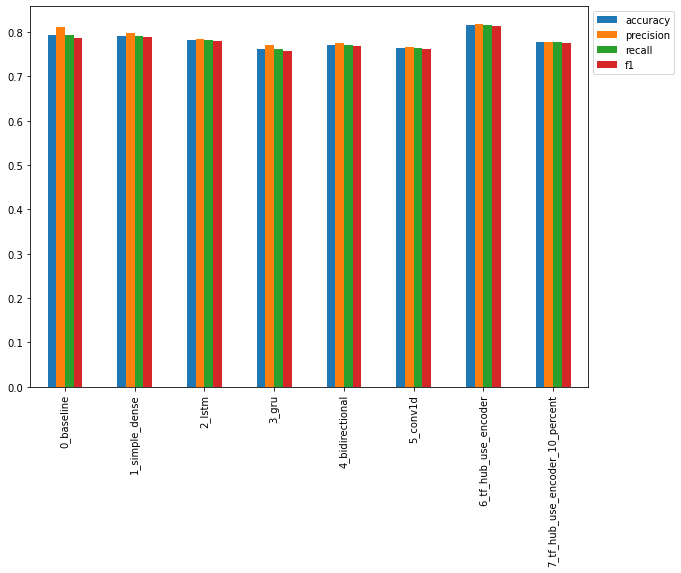

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

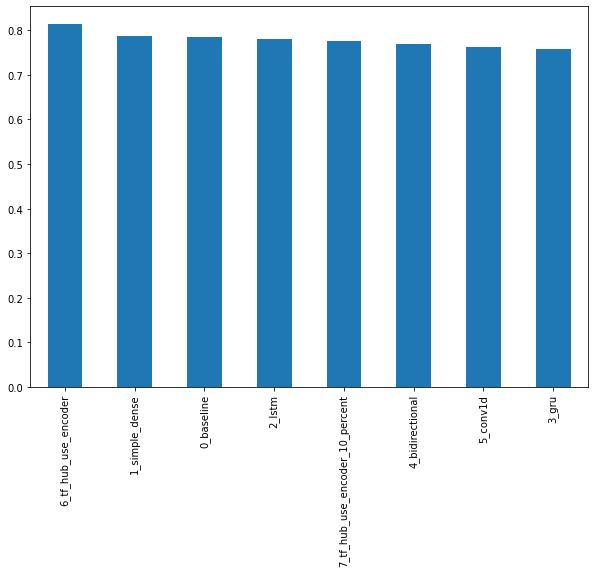

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Uploading our model training logs to TesnorBoard.dev
We can further inspect our model's performance using TensorBoard.dev: https://tensorboard.dev/

In [ ]:
# # View TensorBoard logs of transfer learning modelling experiments (plus all of our other models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs/ \
#   --name "NLP Modelling Experiments ZTM TF Course Video" \
#   --description "Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset" \
#   --one_shot # exit the uploader once uploading is finished

Now I've ran the cell above, my modelling experiments are visable on TensorBoard.dev: https://tensorboard.dev/experiment/Eacboed3RbKPWIGcXe1Z6g/

> 📖 **Resource:** TensorBoard is great for quickly tracking experiments but for larger scale experiments and a whole bunch more tracking options, check out Weights & Biases: https://wandb.ai/site

In [ ]:
# # See the previous TensorBoard Dev experiments you've run...
# !tensorboard dev list

In [ ]:
# If you need to delete an experiment from TensorBoard, you can run the following:
# !tensorboard dev delete --experiment_id Eacboed3RbKPWIGcXe1Z6gB

## Saving and loading a trained model 

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

In [ ]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [ ]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 14ms/step - loss: 0.4289 - accuracy: 0.8150


[0.4289097487926483, 0.8149606585502625]

Now let's save to the `SavedModel` format... (see more on this here: https://www.tensorflow.org/tutorials/keras/save_and_load)

In [ ]:
# Save TF Hub Sentence Ecnoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [ ]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [ ]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 12ms/step - loss: 0.4289 - accuracy: 0.8150


[0.4289097785949707, 0.8149606585502625]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those will predicition probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vice versa.

In [ ]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2021-04-14 06:19:57--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  46.6MB/s    in 25s     

2021-04-14 06:20:23 (36.8 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.i

In [ ]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 12ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [ ]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # these should be in label format

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Create DataFrame with validation sentences, validation labels and best performing model prediction labels + probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] # these are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [ ]:
most_wrong.tail() # these are false negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


Let's remind ourselves of the target labels...
* `0` = not diaster
* `1` = diaster

In [ ]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769820928573608
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523000478744507
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [ ]:
# Check the false negatives (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.06730344891548157
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.05507582053542137
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.05460337549448013
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.054596975445747375
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.04963727295398712
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0.

## Making predictions on the test dataset

In [ ]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")

Pred: 0, Prob: 0.17732585966587067
Text:
@LauraE303B @SheilaGunnReid A war we'll never win? There r 2500 Yezidi women trapped as slaves.We know where they are. Doing nothing is evil

-----

Pred: 0, Prob: 0.04374966397881508
Text:
(rubs lamp greets genie) just need the 1 wish thanks. pls obliterate anyone who has used the hashtag #youcantsitwithus

-----

Pred: 1, Prob: 0.9137933850288391
Text:
Horrible Accident Man Died In Wings of Airplane (29-07-2015) http://t.co/hG8u2kR1Rq

-----

Pred: 1, Prob: 0.9550248384475708
Text:
#USGS M 1.9 - 5km S of Volcano Hawaii: Time2015-08-06 01:04:01 UTC2015-08-05 15:04:01 -10:00 at epicenter... http://t.co/meVvkaXcdE #SM

-----

Pred: 0, Prob: 0.06789832562208176
Text:
@atlwtmgc damn this blew up

-----

Pred: 1, Prob: 0.9011690020561218
Text:
Shot 12 times. Found dead in cuffs after being involved in a car accident. Officers told ambulance not to treat him. https://t.co/MEUDJwaaNg

-----

Pred: 1, Prob: 0.9532992243766785
Text:
Obama Declares Disas

## Your challenge... predicting on Tweets from the wild

Go to your favourite Twitter account and copy one of their latest Tweets.

Then pass that Tweet through our trained model.

Is that Tweet a disaster or not disaster (according to the model)? Is the model right or wrong?

## The speed/score tradeoff

In [ ]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculuate how long predictons took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [ ]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.313799298000049, 0.0004118101023622691)

In [ ]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.024128293999638117, 3.16644278210474e-05)

In [ ]:
# Get results for pretrained GS model
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'f1': 0.8148082644367335,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651}

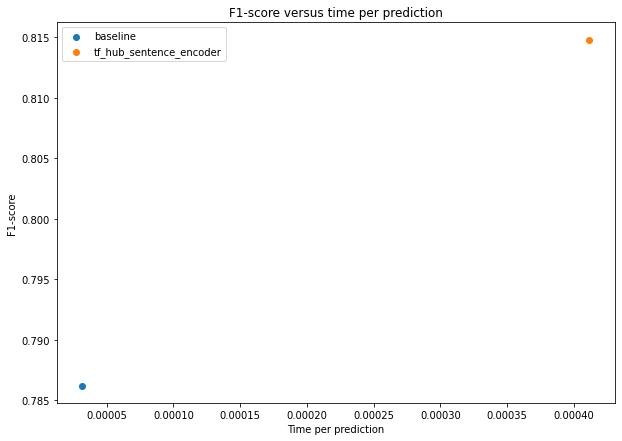

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");

> 📖 **Resource:** See all course materials as well as exercises and extra-curriculum for this notebook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning